In [397]:
# load some useful libraries

import statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter 
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
import warnings
warnings.filterwarnings("ignore")

In [398]:
df = pd.read_csv('combined_data.csv')
van_dijk = df[df['Player'] == 'V. van Dijk']

In [399]:
df = van_dijk[['Date', 'Duels won']]


In [400]:
# # Convert 'Date' column to datetime format and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date')
df.dropna(inplace=True)



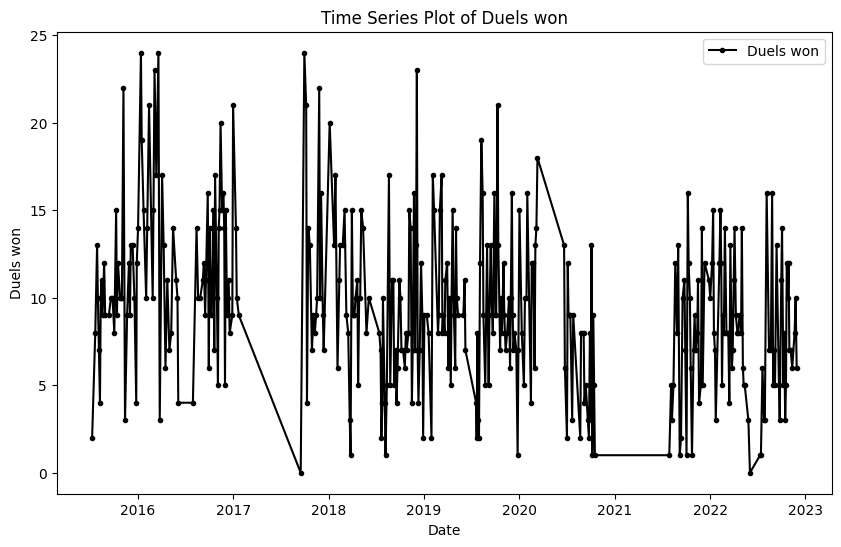

<bound method NDFrame.head of             Date  Duels won
63136 2022-11-29          6
63137 2022-11-25         10
63138 2022-11-21          8
63139 2022-11-12          6
63140 2022-11-06          7
...          ...        ...
63495 2015-08-05          7
63496 2015-08-01         10
63497 2015-07-29         13
63498 2015-07-22          8
63499 2015-07-10          2

[364 rows x 2 columns]>

In [401]:
# Step 2: Exploratory Data Analysis (EDA)
# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Duels won'], label='Duels won',marker='o', linestyle='-', color='black', markersize='3')
plt.title('Time Series Plot of Duels won')
plt.xlabel('Date')
plt.ylabel('Duels won')
plt.legend()
plt.show()
df.head

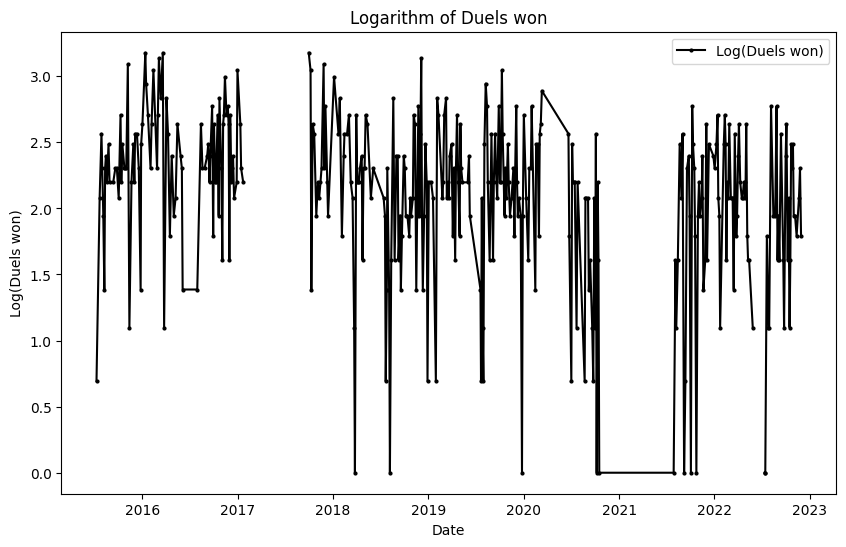

Index(['Date', 'Duels won'], dtype='object')

In [402]:
# Optionally, plot the logarithm of the data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], np.log(df['Duels won']), label='Log(Duels won)',marker='o', linestyle='-', color='black', markersize='2')
plt.title('Logarithm of Duels won')
plt.xlabel('Date')
plt.ylabel('Log(Duels won)')
plt.legend()
plt.show()
df.columns

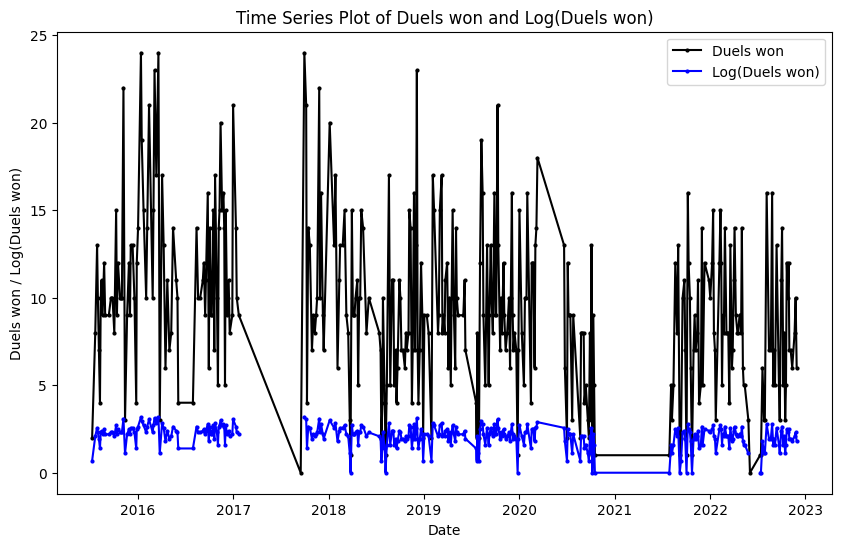

Index(['Date', 'Duels won', 'log_duels_won'], dtype='object')

In [403]:
df['log_duels_won'] = np.log(df['Duels won'])

# Drop rows with NaN values resulting from the lag creation
df.dropna(inplace=True)

# Plot the original time series and the logarithm of 'Duels won'
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Duels won'], label='Duels won', marker='o', linestyle='-', color='black', markersize='2')
plt.plot(df['Date'], df['log_duels_won'], label='Log(Duels won)',marker='o', linestyle='-', color='blue', markersize='2')
plt.title('Time Series Plot of Duels won and Log(Duels won)')
plt.xlabel('Date')
plt.ylabel('Duels won / Log(Duels won)')
plt.legend()
plt.show()
df.columns

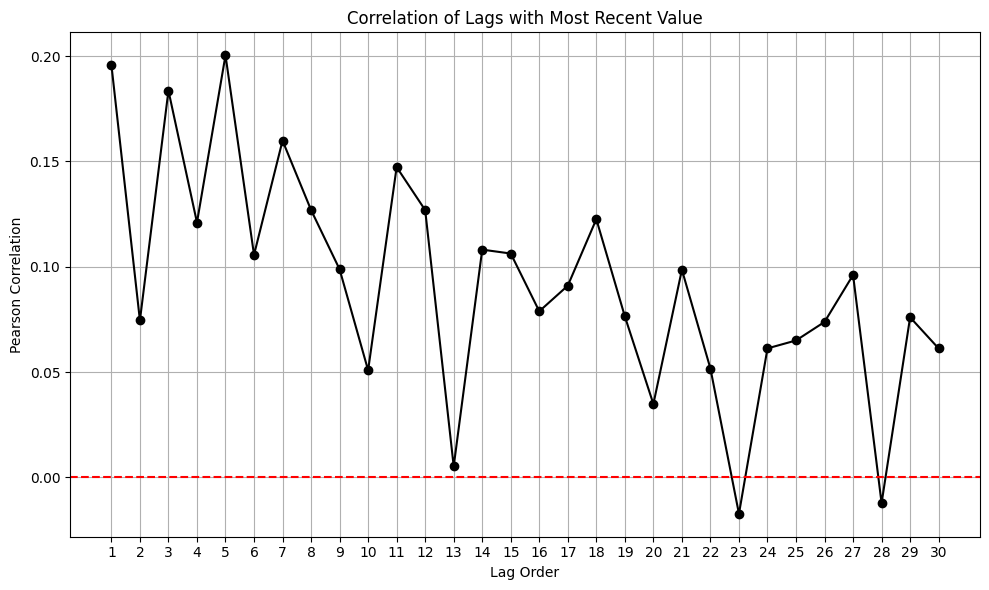

Index(['Date', 'Duels won', 'log_duels_won'], dtype='object')

In [404]:
lags = 30
correlations = []
for lag in range(1, lags + 1):
    # Calculate Pearson correlation
    corr, _ = pearsonr(df['Duels won'].iloc[lag:], df['Duels won'].iloc[:-lag])
    correlations.append(corr)

# Plot the correlation against the order of the lag
plt.figure(figsize=(10, 6))
plt.plot(range(1, lags + 1), correlations, marker='o', linestyle='-', color='black')
plt.title('Correlation of Lags with Most Recent Value')
plt.xlabel('Lag Order')
plt.ylabel('Pearson Correlation')
plt.axhline(y=0, color='r', linestyle='--')  
plt.grid(True)
plt.xticks(range(1, lags + 1))
plt.tight_layout()
plt.show()
df.columns

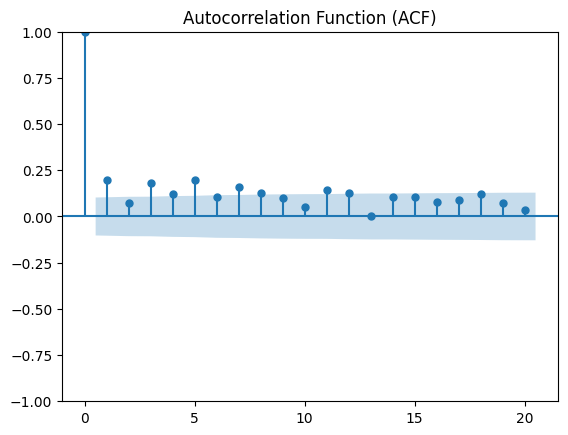

In [405]:
# Step 4: Model Selection
# Plot ACF and PACF plots to determine the order of ARIMA model
plot_acf(df['Duels won'], lags=20)
plt.title('Autocorrelation Function (ACF)')
plt.show()



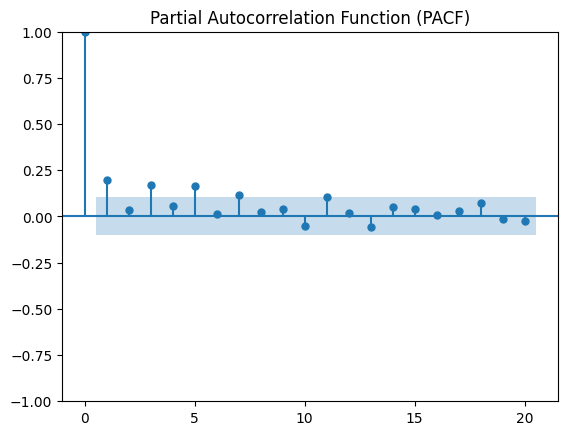

In [406]:

plot_pacf(df['Duels won'], lags=20)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [407]:
# Step 5: Model Training
# Fit the ARIMA model
model = ARIMA(df['Duels won'], order=(1, 1, 0))
model_fit = model.fit()

df.columns

Index(['Date', 'Duels won', 'log_duels_won'], dtype='object')

In [408]:

# Step 6: Model Evaluation
# Print summary of the model
print(model_fit.summary())

# Step 7: Forecasting
# Generate forecasts
forecast = model_fit.forecast(steps=365)

df.columns

                               SARIMAX Results                                
Dep. Variable:              Duels won   No. Observations:                  364
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1125.786
Date:                Mon, 25 Mar 2024   AIC                           2255.572
Time:                        18:47:48   BIC                           2263.361
Sample:                             0   HQIC                          2258.668
                                - 364                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4231      0.047     -8.953      0.000      -0.516      -0.330
sigma2        28.9119      1.924     15.029      0.000      25.142      32.682
Ljung-Box (L1) (Q):                  10.10   Jarque-

Index(['Date', 'Duels won', 'log_duels_won'], dtype='object')

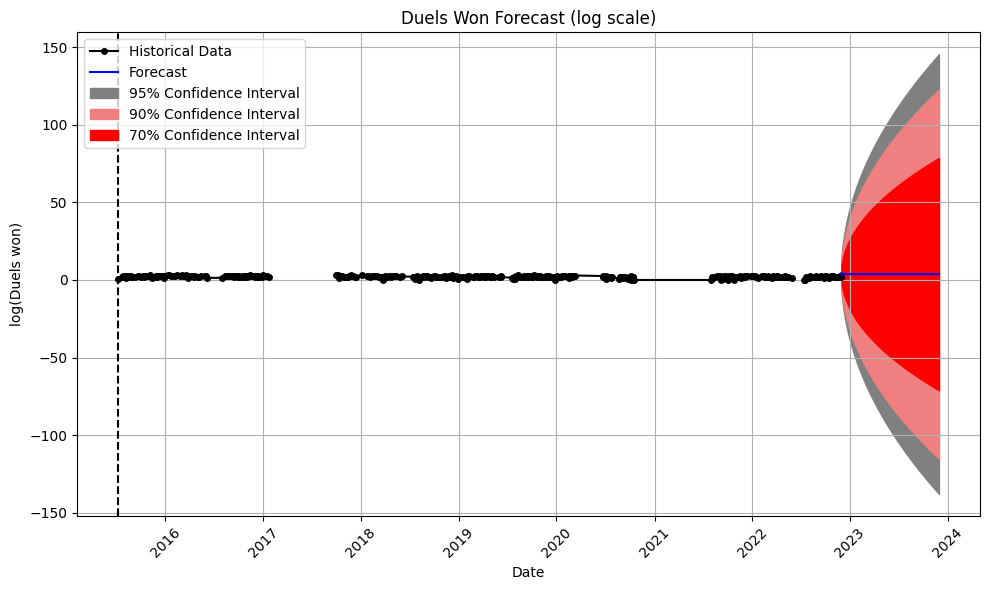

In [409]:

df['Date'] = pd.to_datetime(df['Date'])
# Forecast the next 365 days
forecast = model_fit.get_forecast(steps=365)

# Extract the forecast mean and confidence intervals
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.05)  # 95% confidence interval

# Calculate the 70% and 90% confidence intervals
conf_int_70 = forecast.conf_int(alpha=0.30)  # 70% confidence interval
conf_int_90 = forecast.conf_int(alpha=0.10)  # 90% confidence interval

# Convert forecast index to match the dates if necessary
forecast_dates = pd.date_range(start=df['Date'].iloc[0] + pd.Timedelta(days=1), periods=365)

# Plot the historical data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['log_duels_won'], marker='o', linestyle='-', color='black', markersize=4, label='Historical Data')

# Plot the forecast
plt.plot(forecast_dates, forecast_mean, color='blue', label='Forecast')

# Plot the confidence intervals
plt.fill_between(forecast_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='grey', alpha=1, label='95% Confidence Interval')
plt.fill_between(forecast_dates, conf_int_90.iloc[:, 0], conf_int_90.iloc[:, 1], color='lightcoral', alpha=1, label='90% Confidence Interval')
plt.fill_between(forecast_dates, conf_int_70.iloc[:, 0], conf_int_70.iloc[:, 1], color='red', alpha=1, label='70% Confidence Interval')

# Delineate the start of the forecast with a solid black line
plt.axvline(x=df['Date'].iloc[-1], color='black', linestyle='--')

plt.title('Duels Won Forecast (log scale)')
plt.xlabel('Date')
plt.ylabel('log(Duels won)')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


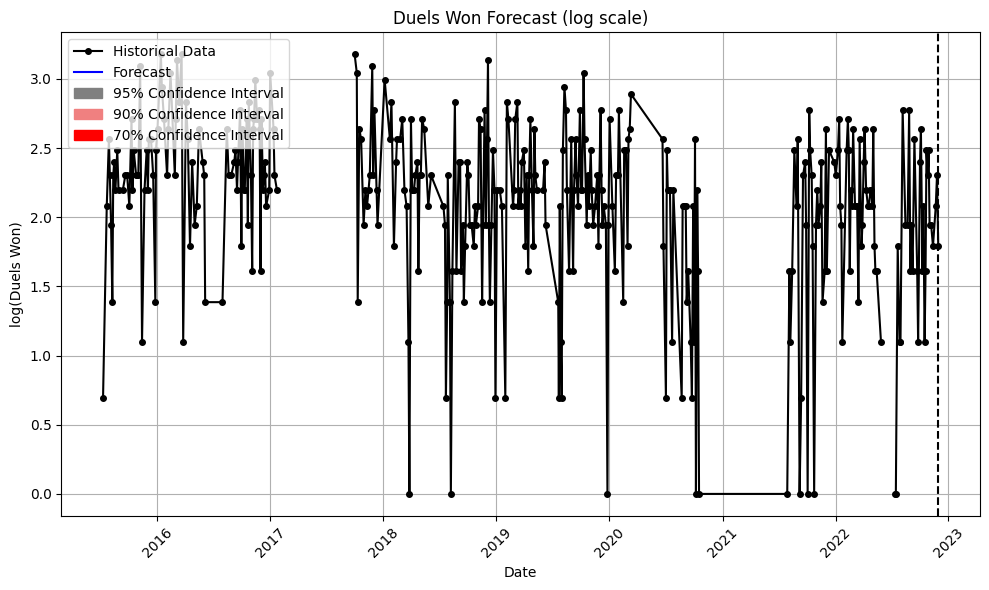

In [410]:
# Fit an ARIMA model (0,1,0) with a constant term to model a random walk with drift
model = ARIMA(df['log_duels_won'], order=(0, 1, 0), trend='t')
model_fit = model.fit()

# Forecast the next 52 weeks
forecast = model_fit.get_forecast(steps=365)

# Extract the forecast mean and confidence intervals
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.05)  # 95% confidence interval

# Calculate the 70% and 90% confidence intervals
conf_int_70 = forecast.conf_int(alpha=0.30)  # 70% confidence interval
conf_int_90 = forecast.conf_int(alpha=0.10)  # 90% confidence interval

# Convert forecast index to match the dates if necessary
forecast_dates = pd.date_range(start=df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=365)

# Plot the historical data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['log_duels_won'], marker='o', linestyle='-', color='black', markersize=4, label='Historical Data')

# Plot the forecast
plt.plot(forecast_dates, forecast_mean, color='blue', label='Forecast')

# Plot the confidence intervals
plt.fill_between(forecast_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='grey', alpha=1, label='95% Confidence Interval')
plt.fill_between(forecast_dates, conf_int_90.iloc[:, 0], conf_int_90.iloc[:, 1], color='lightcoral', alpha=1, label='90% Confidence Interval')
plt.fill_between(forecast_dates, conf_int_70.iloc[:, 0], conf_int_70.iloc[:, 1], color='red', alpha=1, label='70% Confidence Interval')


# Delineate the start of the forecast with a solid black line
plt.axvline(x=df['Date'].iloc[0], color='black', linestyle='--')

plt.title('Duels Won Forecast (log scale)')
plt.xlabel('Date')
plt.ylabel('log(Duels Won)')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
